# Single proliferation event within larger spheroid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance

dim = 3
seed = 67

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4

params = {'EF_glob_adap_acc': {'eta': eta},
          'EF_glob_adap_stab': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_local_adap': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True, 'local_adaptivity': True}, 
          'EB_global_adap': {'eta': eta}
         }


labels = {'EF_glob_adap_acc': 'Glob. adap. EF', 
          'EF_glob_adap_stab': 'Glob. adap. EF\n(with stab. bound)' ,  
          'EF_local_adap': 'Loc. adap. EF', 
          'EB_global_adap': 'Glob. adap. EB'
         }

## Time step sizes as a function of chosen absolute error

In [4]:
cell_list = ut.setup_locally_compressed_spheroid(6,6,6, seed=seed)

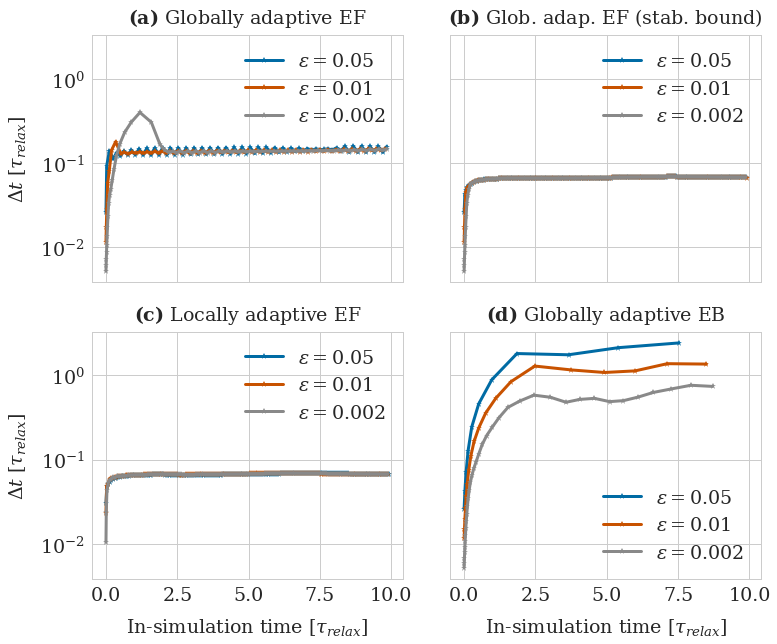

In [5]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

epsilons = [0.05, 0.01, 0.002]

      
for alg in algorithms:
        
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()
   

ax1.set_title(r'$\bf{(a)}$ Globally adaptive EF')
ax2.set_title(r'$\bf{(b)}$ Glob. adap. EF (stab. bound)')
ax3.set_title(r'$\bf{(c)}$ Locally adaptive EF')
ax4.set_title(r'$\bf{(d)}$ Globally adaptive EB')
    
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax3.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')    
ax3.set(xlabel=r'In-simulation time [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time [$\tau_{relax}$]')

plt.savefig('prolif_within_spheroid.pdf', bbox_inches='tight')

Note that the exact amount of overshoot for the globally adaptive EF scheme varies slightly between runs, if the division direction chosen within the setup of the cell configuration is not fixed. (It also varies depending on eta, however, there is no clear trend if larger eta or smaller eta are better.)

##  Dependence of initial step dt_0 and dt at steady state on spheroid size

Can I run this locally, or should I run this on rackham?
I want to
- consider all algorithms
- over a range of spheroid sizes
- average over several seeds and hence cell division directions
- calculate dt_0 as ts[1]-ts[0] and dt_st = ts[-2] - ts[-3], since the last time step may be cut short to reach tf exactly. Might need to average over several last steps.

Do I want to plot the level distribution of the locally adaptive algorithm here?

In [7]:
eps = 0.01
for alg in algorithms:
    params[alg]['eps'] = eps

In [8]:
dt_0s = {}
dt_sts = {}

sizes = [2, 3, 4, 5, 6, 7, 8]
n_seed = 5

for alg in algorithms:
    
    dt_0s[alg] = []
    dt_sts[alg] = []
    
    for l in sizes:
        
        dt_0 = 0.
        dt_st = 0.
        
        for seed in range(n_seed):
            sheet = ut.setup_locally_compressed_spheroid(l,l,l, seed=seed)            
            ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)
            
            dt_0 += ts[1]-ts[0]
            dt_st += ts[-2]-ts[-3]
            
        dt_0s[alg].append(dt_0/n_seed)
        dt_sts[alg].append(dt_st/n_seed)

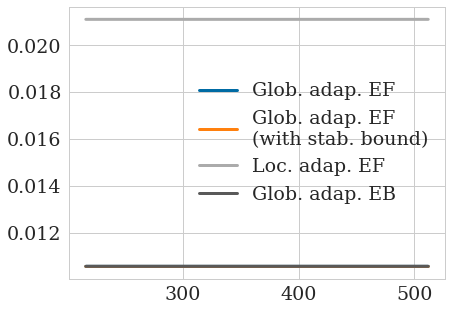

In [11]:
for alg in algorithms:
    plt.plot([l**3 for l in sizes], dt_0s[alg], label=labels[alg])
plt.legend()

Why does the locally adaptive algorithm take larger initial steps? Which dt are we comparing here? The smallest or the largest? I think it's the latter. Then it should be 4 times as large.

In [15]:
dt_0s['EF_local_adap'][0]/dt_0s['EB_global_adap'][0]

1.9991200578750694

Okay, it's twice as large. Does this mean we have 2 levels?

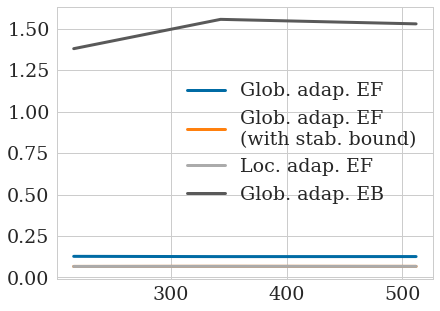

In [12]:
for alg in algorithms:
    plt.plot([l**3 for l in sizes], dt_sts[alg], label=labels[alg])
plt.legend()